# Sensitive time-distance figure

Here we show how to reproduce the plots 2a and 2b in the paper.

The data behind this plot takes a while to generate, so we split this off into a separate script. The script `sensitive_time_distance.py`, which you can find in the same directory as this on the github repo. is used for this. How to run this is described in the `README.md` in the same directory.

This plotting code will begin by reading in the data files that `sensitive_time_distance.py` will create. We have provided the outputs from `sensitive_time_distance.py` that we used in the git repo. so you don't have to regenerate the data files to be able to run this notebook.



## Imports

In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
from matplotlib.colors import LogNorm

from pycbc.cosmology import redshift

%matplotlib inline


In [2]:
# Here we set a flag whether we want source-frame masses or
# not (detector-frame). This determines whether we get
# Fig 2a (False) or 2b (True)
source_frame_masses = False

In [3]:
# Set up max/min time/distance/mass for use
# in plotting / normalizing
max_mass = 0
min_mass = np.inf
max_time = 0
min_time = np.inf
max_dist = 0
min_dist = np.inf

## Set up required dictionaries of inputs

In [4]:
# Set up dictionary of input files
# note that these are outputs to the sensitive_time_distance.py script
# and as such may be in a different location if you run that yourself

input_files = {
    'Optimistic': 'sensitive_time_distance_optimistic.hdf',
    'Pessimistic': 'sensitive_time_distance_pessimistic.hdf',
    'Cutoff': 'sensitive_time_distance_cutoff.hdf',
}

linestyles = {
    'Optimistic': '-',
    'Pessimistic': '--',
    'Cutoff': ':',
}


## Extract information from the files

In [9]:
# Mass in Msol
masses = {}
masses_source = {}
# Time-before-merger to reach SNR 10 (days)
# (or whatever SNR has been defined in the sensitive_distance.py runs)
times = {}
# Distance to the source in Gpc
dists = {}

for input_type, input_filename in input_files.items():
    with h5py.File(input_filename, 'r') as input_file:
        ms = input_file['mass'][:]
        ts = input_file['time'][:] / 86400 # This was defined as seconds in the input files
        ds = input_file['distance'][:]
        mass_range = input_file.attrs['mass_range']
    # The input mass range will have been saved in the attributes
    # of the file, but it could differ between runs. Use the max/min
    # over all cases
    max_mass = max(mass_range[1], max_mass)
    min_mass = max(mass_range[0], min_mass)
    max_time = max(max_time, ts.max())
    min_time = max(min_time, ts.min())

    # distances could be nan if the mass/time combination is not valid
    # Set this to something arbitrarily small to prevent errors
    ds[np.isnan(ds)] = 1e-6

    # If you want to plot source-frame mass (Fig 2b), change this to True
    ms_rshift = ms / (1 + redshift(ds * 1000))

    # In case the output files are not ordered correctly, then sort them by
    # time and then mass:
    tm = np.array(
        list(zip(ts, ms)),
        dtype=[('time', float), ('mass', float)]
    )
    tm_sort = np.argsort(tm, order=['time','mass'])
    masses[input_type] = ms[tm_sort]
    masses_source[input_type] = ms_rshift[tm_sort]
    times[input_type] = ts[tm_sort]
    dists[input_type] = ds[tm_sort]

In [10]:
# Set up the color ranges being used for different times
# If time = 0 (i.e. SNR at merger) is being used, then the
# color map will break

vmin = min([min(t) for t in times.values()]) #  Find the minimum
if vmin == 0:
    vmin = min([np.sort(np.unique(t))[1] / 2 for t in times.values()])
vmax = max([max(t) for t in times.values()])

logvrange = np.log(vmax) - np.log(vmin)
vmin = np.exp(np.log(vmin) - 0.05 * logvrange)
vmax = np.exp(np.log(vmax) + 0.05 * logvrange)

norm = LogNorm(vmin=vmin, vmax=vmax)

In [11]:
# Work out the total number of different times / lines to be plotted
unq_times = np.unique(ts)

## Make the plot

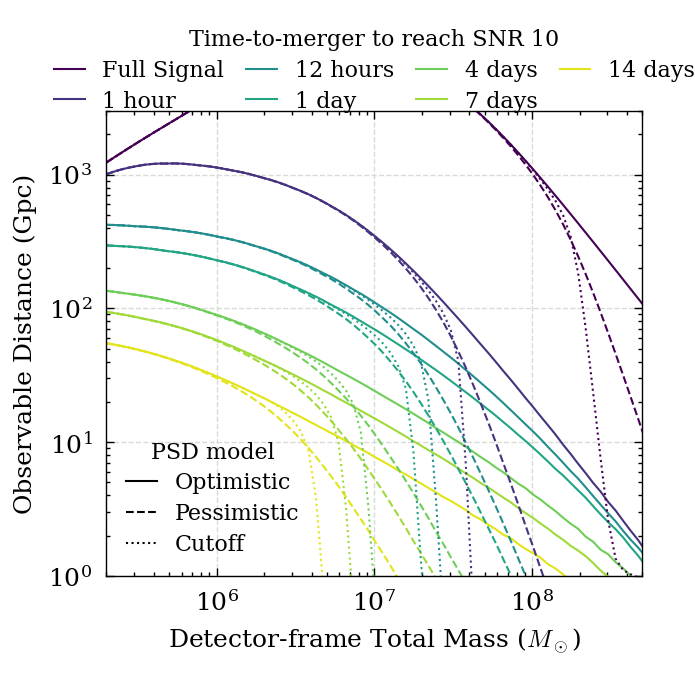

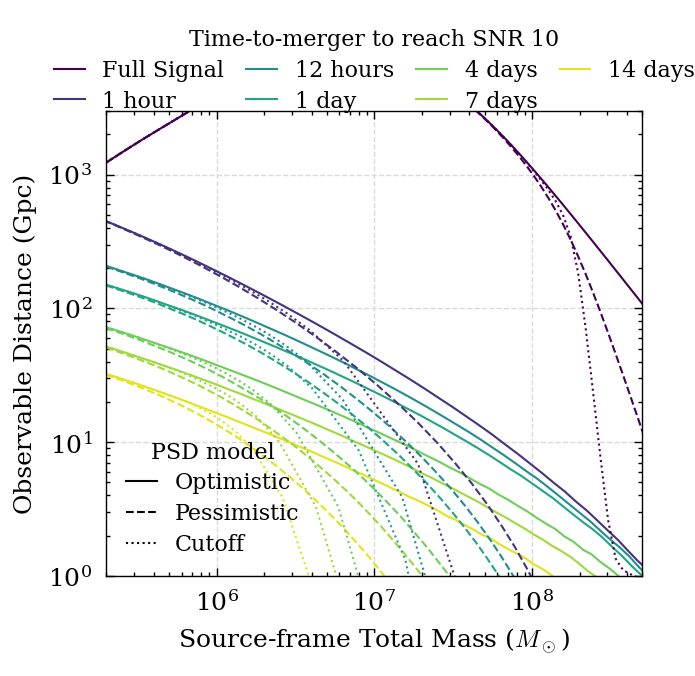

In [13]:
for source_frame_masses in [0,1]:
    if source_frame_masses:
        curr_mass = masses_source
        curr_label = 'Source-frame Total Mass ($M_\odot$)'
        filename='Figure2a.pdf'
    else:
        curr_mass = masses
        curr_label = 'Detector-frame Total Mass ($M_\odot$)'
        filename='Figure2b.pdf'
    with plt.style.context("../paper.mplstyle"):
        line_cmap=plt.get_cmap(None)
        # Make the figure - 1.5 times the normal height so we can see detail
        width = plt.rcParams["figure.figsize"][0]
        height = plt.rcParams["figure.figsize"][1] * 1.5

        fig, ax = plt.subplots(
            1, figsize=(width, height),
        )

        # Plot sensitivity lines for each of the PSDs
        for inp_type, linestyle in linestyles.items():
            # Plot each time of interest
            for t in unq_times:
                if t == 0:
                    # This is a special case due to the color map issue
                    # mentioned above
                    continue
                lgc = times[inp_type] == t
                ax.plot(
                    curr_mass[inp_type][lgc] * 2,
                    dists[inp_type][lgc],
                    color=line_cmap(norm(t)),
                    linestyle=linestyle,
                )
            lgc0 = times[inp_type] == 0
            # Also add the time=0 line
            ax.plot(
                masses[inp_type][lgc0] * 2,
                dists[inp_type][lgc0],
                color=line_cmap(0),
                linestyle=linestyle
            )

        # Make some lines to be added to the legend showing the different PSDs
        for inp_type, linestyle in linestyles.items():
            ax.plot(
                [], [],
                color='k',
                linestyle=linestyle,
                label=inp_type.title()
            )
        leg1 = ax.legend(loc='lower left', title='PSD model')

        # Make the legend showing time colors. Translate time (days)
        # into words nicely.
        time_lines = []
        time_labels = []
        for t in unq_times:
            if t == 0:
                time_lines.append(ax.plot([],[],color=line_cmap(0))[0])
                time_labels.append("Full Signal")
            else:
                time_lines.append(ax.plot([],[],color=line_cmap(norm(t)))[0])
                if t > 1:
                    time_labels.append(f'{t:.0f} days')
                elif t == 1:
                    time_labels.append('1 day')
                elif t == 1 / 24:
                    time_labels.append('1 hour')
                else:
                    time_labels.append(f'{t * 24:.0f} hours')

        ax.legend(
            time_lines,
            time_labels,
            loc='upper center',
            title='Time-to-merger to reach SNR 10',
            bbox_to_anchor=(0.5, 1.22),
            ncol=4
        )

        ax.add_artist(leg1)

        # Labels for axes:
        ax.set_xlabel(curr_label)
        ax.set_ylabel('Observable Distance (Gpc)')

        # plotting tweaks
        ax.loglog()
        ax.set_xlim([2e5, 5e8])
        ax.set_ylim([1, 3e3])
        ax.grid(zorder=-100)  # Grid _behind_ data
        
        #plt.savefig(filename)